In [1]:
root = '../'

import os, sys
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd

from functools import cmp_to_key

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Basic settings
torch.manual_seed(470)
torch.cuda.manual_seed(470)

#!pip install easydict
from easydict import EasyDict as edict

args = edict()
args.batch_size = 64
args.nlayers = 2

args.embedding_size = 4
args.ninp = 4 + args.embedding_size
args.nhid = 64 #512

args.dropout = 0.2
args.gpu = True

args.tensorboard = False
args.train_portion = 0.7
args.slide_deck_N = 5
args.slide_deck_embedding_size = 512
args.padding_idx = 0
args.max_seq_length = 8

# Decoder
args.latent_vector_dim = 28

# GAN
args.n_epochs = 200
args.lr = 0.00005
args.n_cpu = 4
args.latent_dim = 100
args.channels = 1
args.clip_value = 0.1
args.sample_interval = 400
args.n_critic = 2
args.b1 = 0.5
args.b2 = 0.999

device = 'cuda:0' if torch.cuda.is_available() and args.gpu else 'cpu'
# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [3]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [4]:
BB_TYPES = [
    '<pad>',
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

In [5]:
def draw_bbs(shape, bbs):
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())
    if (torch.is_tensor(shape)):
        [h, w] = np.array(shape.tolist())
        shape = (h, w)
    
    h, w = shape
    fig, ax = plt.subplots(1)
    background=patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='b', facecolor='black')
    ax.add_patch(background)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.autoscale(True, 'both')
    plt.show()
    return

def get_BB_types(bbs):
    return bbs[:, 4]

class BBSlideDeckDataset(Dataset):
    """ Slide Deck Dataset but with Bounding Boxes"""
    def __init__(self, slide_deck_data, slide_deck_N, transform=None):
        self.transform = transform

        self.slide_deck_data = {}

        for key, val in slide_deck_data.items():
            n = len(val['slides'])
            for i in range(n):
                if (n - i < slide_deck_N):
                    break
                if (i % slide_deck_N == 0 or (n - i) == slide_deck_N):
                    current_slide_deck = {
                        'slides': val['slides'][i:(i+slide_deck_N)],
                        'shape': val['shape'],
                    }
                    self.slide_deck_data[str(key) + '_' + str(i)] = current_slide_deck
        print(len(self.slide_deck_data))
        self.slide_deck_ids = list(self.slide_deck_data.keys())
    
    def __len__(self):
        return len(self.slide_deck_ids)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        slide_deck_id = self.slide_deck_ids[idx]
        (h, w) = self.slide_deck_data[slide_deck_id]["shape"]
        lengths_slide_deck = []
        
        slides = []
        max_len_bbs = args.max_seq_length
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            lengths_slide_deck.append(min(max_len_bbs, len(slide)))
            np_slide = np.zeros((max_len_bbs, 5), dtype=np.double)
            for i, bb in enumerate(slide):
                if (i >= max_len_bbs):
                    break
                np_slide[i] = bb
            slides.append(np_slide)
        ref_slide = slides[0]
        slide_deck = slides[1:]
        length_ref_types = lengths_slide_deck.pop(0)
        sample = {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": get_BB_types(ref_slide),
            "slide_deck": np.asarray(slide_deck),
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

        if self.transform:
            sample = self.transform(sample)
        return sample


In [6]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)
            lengths_slide_deck = lengths_slide_deck[:self.N]

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        lengths_slide_deck.append(length_ref_types)
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))

        idxs = np.array([*range(0, len(lengths_slide_deck))], dtype=np.int32)
        np.random.shuffle(idxs)

        slide_deck = slide_deck[idxs]

        lengths_slide_deck = np.array(lengths_slide_deck, dtype=np.int32)
        lengths_slide_deck = lengths_slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck.tolist()
        
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        length_ref_types = lengths_slide_deck.pop()
        ref_types = get_BB_types(ref_slide)

        slide_deck = np.asarray(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        idxs = [*range(0, len(lengths_slide_deck))]

        def by_length(p1, p2):
            return lengths_slide_deck[p2] - lengths_slide_deck[p1]
        idxs = sorted(idxs, key=cmp_to_key(by_length))

        shape = torch.tensor([h, w], dtype=torch.float64)
        ref_slide = torch.from_numpy(ref_slide).float()
        ref_types = torch.from_numpy(ref_types).float()
        
        slide_deck = torch.from_numpy(slide_deck).float()
        lengths_slide_deck = torch.tensor(lengths_slide_deck, dtype=torch.int32)
        
        slide_deck = slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck[idxs]

        length_ref_types = torch.tensor(length_ref_types, dtype=torch.int32)

        return {
            "shape": shape,
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types
        }

In [7]:
def process_slide_deck_dataset(all_dataset):
    slide_deck_data = {}
    for entrance in all_dataset.iloc:
        slide_deck_id = entrance['Slide Deck Id']
        
        slide_id = entrance["Slide Id"]
        if (slide_deck_id not in slide_deck_data):
            slide_deck_data[slide_deck_id] = {
                'slides': {},
                'shape': (entrance['Image Height'], entrance['Image Width'])
            }
        
        if slide_id not in slide_deck_data[slide_deck_id]["slides"]:
            slide_deck_data[slide_deck_id]["slides"][slide_id] = []
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type
        ]).T
        slide_deck_data[slide_deck_id]['slides'][slide_id].append(bb)
    for key in slide_deck_data.keys():
        
        # if key == 100:
        #     for (id, value) in slide_deck_data[key]["slides"].items():
        #         print(56, id)
        #         draw_bbs(slide_deck_data[key]["shape"], value)

        values = list(slide_deck_data[key]["slides"].values())
        slide_deck_data[key]["slides"] = [np.asarray(value) for value in values]
    return slide_deck_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [8]:
csv_files_root = os.path.join(os.path.dirname(os.getcwd()), "data", "bbs")

dataset = None

for _, dirs, files in os.walk(csv_files_root):
    for file in files:
        if file.endswith('.csv'):
            print('file: ', file)
            csv_file_path = os.path.join(csv_files_root, file)
            cur_dataset = pd.read_csv(csv_file_path)
            if dataset is None:
                dataset = cur_dataset
            else:
                dataset = pd.concat([dataset, cur_dataset])
slide_deck_data = process_slide_deck_dataset(dataset)

division = int(args.train_portion * len(slide_deck_data))

train_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, 0, division),
    slide_deck_N=args.slide_deck_N+1,
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)

test_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, division, len(slide_deck_data)),
    slide_deck_N=args.slide_deck_N+1,
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)


file:  slide_deck_dataset_bmvc13.csv
file:  slide_deck_dataset_acl17.csv
file:  slide_deck_dataset_bmvc12.csv
file:  slide_deck_dataset_cvpr10.csv
file:  slide_deck_dataset_icml20.csv
file:  slide_deck_dataset_eccv20.csv
file:  slide_deck_dataset_emnlp17.csv
file:  slide_deck_dataset_icml19.csv
file:  slide_deck_dataset_nips18.csv
file:  slide_deck_dataset_eccv14.csv
file:  slide_deck_dataset_nips19.csv
file:  slide_deck_dataset_naacl19.csv
file:  slide_deck_dataset_eccv12.csv
file:  slide_deck_dataset_fg15.csv
file:  slide_deck_dataset_iclr20.csv
file:  slide_deck_dataset_emnlp18.csv
file:  slide_deck_dataset_acl18.csv
file:  slide_deck_dataset_cvpr20.csv
file:  slide_deck_dataset_acl20.csv
22212
7028


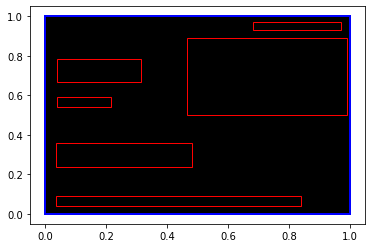

In [9]:
single = train_slide_deck_dataset[0]
draw_bbs(single["shape"], single["ref_slide"])
print(single["ref_slide"].shape)
print(single["shape"])
# print(single["ref_types"])
# for i in range(5):
#     print(single["slide_deck"][i])
# print(single["lengths_slide_deck"])

In [10]:
def SortByRefSlide(batch):
    idx = [*range(batch["ref_slide"].shape[0])]

    def by_length(p1, p2):
        return batch["length_ref_types"][p2] - batch["length_ref_types"][p1]
    idx = sorted(idx, key=cmp_to_key(by_length))

    idx = torch.tensor(idx).to(device).long()
    for prop in batch.keys():
        batch[prop] = batch[prop][idx]
    
    return batch
        
        

In [11]:
train_loader = DataLoader(train_slide_deck_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_slide_deck_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


In [109]:
class SlideEncoder(nn.Module):
    def __init__(self):
        super(SlideEncoder, self).__init__()
        ninp = args.ninp
        nhid = args.nhid
        nlayers = args.nlayers
        dropout = args.dropout
        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, args.padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(ninp, nhid, nlayers, bias=True).float()

    def forward(self, x, states, lengths=None):
        """
        Args:
            x: tensor(B, L, 5)
            states: List[Tuple(h_0, c_0), ..., Tuple(h_{B-1}, c_{B-1})]
            lengths: tensor(B)
        """
        idxs = [*range(0, len(lengths))]
        def by_lengths(p1, p2):
            return lengths[p2] - lengths[p1]

        idxs = sorted(idxs, key=cmp_to_key(by_lengths))

        x = x[:, idxs]
        lengths = lengths[idxs]
        
        input = x[:, :, :-1]
        types = x[:, :, -1:].long()
        types = torch.squeeze(self.embed(types))
        input = torch.cat((input, types), dim=-1)

        output = self.dropout(input)
        

        output = torch.nn.utils.rnn.pack_padded_sequence(output, lengths.cpu())

        h_0 = torch.stack([h for (h, _) in states], dim=0)
        c_0 = torch.stack([c for (_, c) in states], dim=0)

        (output, context_vector) = self.lstm(output.to(device), (h_0, c_0))
        output, lengths = torch.nn.utils.rnn.pad_packed_sequence(output, total_length = args.max_seq_length)
        return (output, context_vector)

class SlideDeckEncoder(nn.Module):
    def __init__(self):
        super(SlideDeckEncoder, self).__init__()
        self.slide_encoder = SlideEncoder()

        input_size = args.nhid * args.slide_deck_N
        output_size = args.slide_deck_embedding_size

        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        return

    def _get_init_states(self, x):
        init_states = [
            (torch.zeros((x.size(1), args.nhid)).to(x.device),
            torch.zeros((x.size(1), args.nhid)).to(x.device))
            for _ in range(args.nlayers)
        ]
        return init_states
    
    def forward(self, xs, lengths):
        states = None
        embedding = []
        for i, x in enumerate(xs):
            if states is None:
                states = self._get_init_states(x)
            length = lengths[i]
            output, states = self.slide_encoder(x, states, length)
            output = output[length.long() - 1,:,:]
            idxs = torch.arange(args.batch_size)
            output = output[idxs, idxs, :]
            embedding.append(output.squeeze())
        
        output = torch.cat(embedding, dim=-1)
        output = self.relu(self.linear(output))
        return output

In [64]:
model = SlideDeckEncoder().to(device)

for epoch in range(args.n_epochs):
    for batch in train_loader:
        xs = torch.transpose(batch["slide_deck"], 0, 1)
        xs = torch.transpose(xs, 1, 2)
        lengths = torch.transpose(batch["lengths_slide_deck"], 0, 1)
        slide_deck_embedding = model(xs, lengths)

RuntimeError: Input, output and indices must be on the current device

In [110]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, torch.autograd.Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return torch.autograd.Variable(y_one_hot) if isinstance(y, torch.autograd.Variable) else y_one_hot

class Generator(nn.Module):
    def __init__(self, embed_weights=None, ganlike=True):
        super(Generator, self).__init__()
        self.ganlike = ganlike
        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, padding_idx=0)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=args.latent_vector_dim + args.embedding_size, hidden_size=args.nhid, num_layers=2, 
            batch_first=True, dropout=args.dropout, bias=True)
        self.linear1 = nn.Linear(args.slide_deck_embedding_size, args.nhid)
        self.linear2 = nn.Linear(args.nhid, 4)
        if embed_weights is not None:
            self.embed.weight.data = embed_weights
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            # if normalize:
            #     layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.gen_model = nn.Sequential(
            *block(args.nhid, 32, normalize=False),
            *block(32, 32),
            nn.Linear(32, 4),
            nn.Tanh()
        )


    def forward(self, x, z, slide_deck_embedding, lengths=None):
        """

        Args:
            x (tensor): bb labels, (Batch_size, Sequence_size)
            z (tensor): latent vector, (Batch_size, latent_vector_dim)
            slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            lengths (tensor): (Batch_size,)

        Returns:
            bb sequence: (tensor), (Batch_size, Sequence_size, 5)
        """
        # print(x.shape, z.shape, slide_deck_embedding.shape, lengths)
        x = x.int()
        (Batch_size, Sequence_size) = x.shape
        temp_input_1 = self.dropout(self.embed(x))   # Batch_size, Sequence_size, input_size
        # print(temp_input_1)
        # print("1",temp_input_1.shape)
        temp_input_2 = z.unsqueeze(1).repeat((1, Sequence_size, 1))
        # print("2",temp_input_2.shape)
        input_1 = torch.cat((temp_input_2, temp_input_1), dim=-1)
        # print(input_1.shape)
        input_1 = torch.nn.utils.rnn.pack_padded_sequence(input_1, lengths.cpu(), batch_first=True)
        # print(input_1.data.shape)
        # print("3",input_1.shape)
        hidden_0 = self.dropout(self.linear1(slide_deck_embedding)).unsqueeze(0).repeat((2, 1, 1))
        # print("4",hidden_0.shape)
        c_0 = torch.zeros(size=(2, Batch_size, args.nhid)).to(device)
        # print("5",c_0.shape)
        output, (h_n, c_n) = self.lstm(input_1.to(device), (hidden_0, c_0))
        # print(output.data.shape)
        output, length = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=args.max_seq_length)

        # output = output.transpose(0, 1)
        if self.ganlike:
            # output = output.transpose(1, 2)
            # print(output.shape)
            output = self.gen_model(output)
        else:
            output = self.linear2(output)

        return output, (h_n, c_n)

In [95]:
#print(args.batch_size)
mydec = Generator()
z = torch.randn((args.batch_size, args.latent_vector_dim))
s = SortByRefSlide(list(train_loader)[0])
# print(len(s))
# for sl in s:
#     print(sl)
#     print(s[sl].shape)

idx = [i for i in range(s['ref_types'].size(0)-1, -1, -1)]
idx = torch.LongTensor(idx)
#print(idx)
t = s['ref_types']
l = s['length_ref_types']
#print(t,l)
v = mydec(x=t, z=z, slide_deck_embedding=torch.randn((args.batch_size, args.slide_deck_embedding_size)), lengths=s['length_ref_types'])
# draw_bbs(,)
v[0].shape

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cuda:0 and hidden tensor at cpu

In [116]:
class Discriminator(nn.Module):
    def __init__(self, embed_weights=None):
        super(Discriminator, self).__init__()

        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, padding_idx=0)
        self.dropout = nn.Dropout(args.dropout)
        self.lstm = nn.LSTM(input_size = args.ninp, hidden_size=args.nhid, num_layers=args.nlayers, 
            batch_first=True, bias=True)
        self.linear1 = nn.Linear(args.slide_deck_embedding_size, args.nhid)
        self.d_model = nn.Sequential(
            nn.Linear(args.nhid, args.nhid//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(args.nhid//2, args.nhid//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(args.nhid//2, 1)
        )
        if embed_weights is not None:
            self.embed.weight.data = embed_weights


    def forward(self, x, bb, slide_deck_embedding, lengths=None):
        """

        Args:
            x (tensor): type labels, (Batch_size, Sequence_size)
            bb (tensor): (Batch_size, Sequence_size, 4)
            slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            length (tensor): (Batch_size,)

        Returns:
            
        """
        x = x.int()
        
        (Batch_size, _) = x.shape
        temp_input_1 = self.dropout(self.embed(x))   # Batch_size, Sequence_size, input_size
        input_1 = torch.cat((bb, temp_input_1), dim=-1)
        input_1 = torch.nn.utils.rnn.pack_padded_sequence(input_1, lengths.cpu(), batch_first=True)

        h_0 = self.dropout(self.linear1(slide_deck_embedding)).unsqueeze(0).repeat((2, 1, 1))
        c_0 = torch.zeros(size=(2,Batch_size, args.nhid)).to(device)
        output, (h_n, c_n) = self.lstm(input_1.to(device), (h_0, c_0))
        output, length = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=args.max_seq_length)
        
        output = output[:,length-1,:].squeeze()
        idxs = torch.arange(args.batch_size)
        output = output[idxs, idxs, :]
        #print(output[:, :10])
        output = self.d_model(output.squeeze())
        #print(output[:, :10])
        return output

In [106]:
c = Discriminator()

z = torch.randn((args.batch_size, args.latent_vector_dim))
s = SortByRefSlide(list(train_loader)[0])
# print(len(s))
# for sl in s:
#     print(sl)
#     print(s[sl].shape)
# print(v[0])
sss = c(x=s['ref_types'], bb = v[0], slide_deck_embedding=torch.randn((args.batch_size, args.slide_deck_embedding_size)), lengths=s['length_ref_types'])
sss

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cuda:0 and hidden tensor at cpu

In [ ]:
def save_model(model, epoch="last"):
    torch.save(model.state_dict(),  result_dir / f'{type(model).__name__}_{mode}.ckpt')

def load_model(model, epoch="last"):
    if os.path.exists(result_dir / f'{type(model).__name__}_{mode}.ckpt'):
        model.load_state_dict(torch.load(result_dir / f'{type(model).__name__}_{mode}.ckpt'))

def load_model(model, epoch="last"):
    if os.path.exists(result_dir / f'{type(model).__name__}_{mode}.ckpt'):
        model.load_state_dict(torch.load(result_dir / f'{type(model).__name__}_{mode}.ckpt'))

In [ ]:
num_trial=0
result_dir= Path(root) / 'results'
parent_dir = result_dir / f'trial_{num_trial}'
# while parent_dir.is_dir():
#     num_trial = int(parent_dir.name.replace('trial_',''))
#     parent_dir = result_dir / f'trial_{num_trial+1}'

# Modify parent_dir here if you want to resume from a checkpoint, or to rename directory.
# parent_dir = result_dir / 'trial_99'
print(f'Logs and ckpts will be saved in : {parent_dir}')

log_dir = parent_dir
ckpt_dir = parent_dir
encoder_ckpt_path = parent_dir / 'encoder.pt'
generator_ckpt_path = parent_dir / 'generator.pt'
discriminator_ckpt_path = parent_dir / 'discriminator.pt'
writer = SummaryWriter(log_dir)

Logs and ckpts will be saved in : ..\results\trial_0


In [ ]:
for k in list(train_loader)[0].keys():
    print(k,list(train_loader)[0][k].shape )

shape torch.Size([64, 2])
ref_slide torch.Size([64, 8, 5])
ref_types torch.Size([64, 8])
slide_deck torch.Size([64, 5, 8, 5])
lengths_slide_deck torch.Size([64, 5])
length_ref_types torch.Size([64])


In [113]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [125]:
encoder = SlideDeckEncoder().to(device)
discriminator = Discriminator(encoder.slide_encoder.embed.weight.data).to(device)
generator = Generator(encoder.slide_encoder.embed.weight.data, False).to(device)

models = {
    "discriminator": discriminator,
    "encoder" : encoder,
    "generator" : generator,
}

optimizers = {
    "discriminator": torch.optim.RMSprop(models["discriminator"].parameters(), lr=args.lr),
    "generator": torch.optim.RMSprop(models["generator"].parameters(), lr=args.lr),
    "encoder" : torch.optim.RMSprop(models["encoder"].parameters(), lr=args.lr)
}

Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

In [126]:
def run_epoch(models, optimizers, is_train=True, dataloader=None):
    batches_done = 0
    for epoch in range(args.n_epochs):
        total_loss_G = 0
        total_loss_D = 0
        G_num = 0
        D_num = 0
        loss_G = 0
        loss_D = 0
        if is_train:
            for model in models:
                models[model].train()
        else:
            for model in models:
                models[model].eval()
        
        for i, batch in enumerate(dataloader):
            batch = SortByRefSlide(batch)

            # ['shape', 'ref_slide', 'ref_types', 'slide_deck', 'lengths_slide_deck', 'length_ref_types']

            # conditioning
            x_slide_deck = batch["slide_deck"].to(device)
            length_ref = batch["length_ref_types"].to(device)
            ref_types = batch["ref_types"].to(device)
            ref_slide = batch["ref_slide"].to(device)

            x_slide_deck = torch.transpose(x_slide_deck, 0, 1)
            x_slide_deck = torch.transpose(x_slide_deck, 1, 2)
            lengths_slide_deck = torch.transpose(batch["lengths_slide_deck"], 0, 1).to(device)
            
            optimizers["encoder"].zero_grad()
            optimizers["discriminator"].zero_grad()

            slide_deck_embedding = models['encoder'](x_slide_deck, lengths_slide_deck)
            
            batch_size, _ = ref_types.shape

            # Sample noise as generator input
            z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (batch_size, args.latent_vector_dim))))
            
            #   x (tensor): bb labels, (Batch_size, Sequence_size)
            #     z (tensor): latent vector, (Batch_size, latent_vector_dim)
            #     slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            #     length (tensor): (Batch_size,)
            # (batch_size, seq, 4)
            
            # Configure input
            # both have ref_types
            
            real_layouts_bbs = ref_slide[:,:,:-1]

            fake_layouts_bbs = models['generator'](ref_types, z, slide_deck_embedding, length_ref)[0].detach()

    #        print("true", real_layouts_bbs[:,:,:4])
   #         print("fake", fake_layouts_bbs[:,:,:4])


  #          print("true: ", models["discriminator"](ref_types, real_layouts_bbs, slide_deck_embedding, length_ref))
 #           print("false: ", models["discriminator"](ref_types, fake_layouts_bbs, slide_deck_embedding, length_ref))

#            break

            loss_D = (-torch.mean(models["discriminator"](ref_types, real_layouts_bbs, slide_deck_embedding, length_ref))
                + torch.mean(models["discriminator"](ref_types, fake_layouts_bbs, slide_deck_embedding, length_ref)))
            #     x (tensor): type labels, (Batch_size, Sequence_size)
            #     bb (tensor): (Batch_size, Sequence_size, 4)
            #     slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            #     length (tensor): (Batch_size,)
            total_loss_D += loss_D.item()
            D_num += 1
            loss_D.backward()
            optimizers["discriminator"].step()
            optimizers["encoder"].step()

            # Clip weights of discriminator
            # for p in models["discriminator"].parameters():
            #     p.data.clamp_(-args.clip_value, args.clip_value)

            # Train the generator every n_critic iterations
            if i % args.n_critic == 0:
                optimizers["encoder"].zero_grad()
                optimizers["generator"].zero_grad()

                slide_deck_embedding = models['encoder'](x_slide_deck, lengths_slide_deck)
                layouts_bbs = models['generator'](ref_types, z, slide_deck_embedding, length_ref)[0]
                
                # Adversarial loss
                loss_G = -torch.mean(models["discriminator"](ref_types, layouts_bbs, slide_deck_embedding, length_ref))
                total_loss_G += loss_G.item()
                G_num += 1
                loss_G.backward()
                optimizers["generator"].step()
                optimizers["encoder"].step()
        
            #if batches_done % args.sample_interval == 0:
            batches_done += 1
           
        print(
            "[Epoch %d/%d] [D loss: %f | Steps: %d] [G loss: %f Steps: %d]"
            % (epoch, args.n_epochs, total_loss_D/D_num, D_num, total_loss_G/G_num, G_num)
        )

In [127]:
run_epoch(models, optimizers, True, train_loader)

[Epoch 0/200] [D loss: -0.006190 | Steps: 83] [G loss: 0.130889 Steps: 42]
[Epoch 1/200] [D loss: 0.002810 | Steps: 83] [G loss: 0.084845 Steps: 42]
[Epoch 2/200] [D loss: 0.001768 | Steps: 83] [G loss: 0.081954 Steps: 42]
[Epoch 3/200] [D loss: -0.001177 | Steps: 83] [G loss: 0.081965 Steps: 42]
[Epoch 4/200] [D loss: -0.001507 | Steps: 83] [G loss: 0.076024 Steps: 42]
[Epoch 5/200] [D loss: 0.000411 | Steps: 83] [G loss: 0.068442 Steps: 42]
[Epoch 6/200] [D loss: -0.000185 | Steps: 83] [G loss: 0.058063 Steps: 42]
[Epoch 7/200] [D loss: -0.002667 | Steps: 83] [G loss: 0.046102 Steps: 42]
[Epoch 8/200] [D loss: 0.000406 | Steps: 83] [G loss: 0.033990 Steps: 42]
[Epoch 9/200] [D loss: 0.000384 | Steps: 83] [G loss: 0.036905 Steps: 42]
[Epoch 10/200] [D loss: 0.000034 | Steps: 83] [G loss: 0.041047 Steps: 42]
[Epoch 11/200] [D loss: -0.000057 | Steps: 83] [G loss: 0.035779 Steps: 42]
[Epoch 12/200] [D loss: -0.001177 | Steps: 83] [G loss: 0.032657 Steps: 42]
[Epoch 13/200] [D loss: -0.0

In [131]:
for model in models:
    models[model].eval()

batch = list(test_loader)[0]
batch = SortByRefSlide(batch)
x_slide_deck = batch["slide_deck"].to(device)
length_ref = batch["length_ref_types"].to(device)
ref_types = batch["ref_types"].to(device)
ref_slide = batch["ref_slide"].to(device)

x_slide_deck = torch.transpose(x_slide_deck, 0, 1)
x_slide_deck = torch.transpose(x_slide_deck, 1, 2)
lengths_slide_deck = torch.transpose(batch["lengths_slide_deck"], 0, 1).to(device)

optimizers["encoder"].zero_grad()
optimizers["discriminator"].zero_grad()

slide_deck_embedding = models['encoder'](x_slide_deck, lengths_slide_deck)

batch_size, _ = ref_types.shape

# Sample noise as generator input
z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (batch_size, args.latent_vector_dim))))
fake_layouts_bbs = models['generator'](ref_types, z, slide_deck_embedding, length_ref)[0].detach()
real_layouts_bbs = ref_slide[:,:,:-1]
    

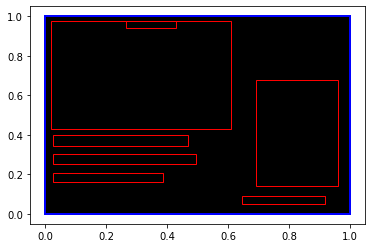

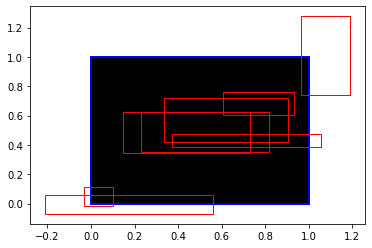

In [153]:
draw_bbs((1,1),real_layouts_bbs[4])
draw_bbs((1,1), fake_layouts_bbs[4])